In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import warnings
warnings.filterwarnings('ignore')

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:

# len(calib['So'].join(df[["V3k", "Vmod", "Qs", "Qw", "F21", 'eF21', 'elgWi']]).dropna())

In [4]:
# df = pd.read_csv("edd_cf4_refined.csv", sep='|')
df = pd.read_csv("btfr_brent_updated.csv", sep='|')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df = df.rename(columns={"e_F21":"eF21"})

df = df.set_index("PGC")
print(df.columns)
print(len(df))

df.head()

Index(['flag', 'DM_av', 'DM_riz', 'eDM_riz', 'DM_W1', 'eDM_W1', 'PGC1', 'Nest',
       'logMs_riz', 'logMs_W1', 'logM_gas', 'logMb', 'Vhel', 'Vls', 'v3k', 'f',
       'lgWmxi', 'elgWi', 'F21', 'eF21', 'inc', 'einc', 'g***', 'r***', 'i***',
       'z***', 'w1***', 'Qs', 'Qw', 'RA', 'DE', 'GLong', 'GLat', 'SGL', 'SGB',
       'Nkt', 'N15', 'SGLg', 'SGBg', 'Vhg', 'Vlsg', 'V3kg', 'fg'],
      dtype='object')
10154


,flag,DM_av,DM_riz,eDM_riz,DM_W1,eDM_W1,PGC1,Nest,logMs_riz,logMs_W1,...,SGL,SGB,Nkt,N15,SGLg,SGBg,Vhg,Vlsg,V3kg,fg
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.54,NaN,NaN,34.54,0.28,73150,200275,NaN,10.917,...,341.6440,20.7388,0,7,341.4922,20.7395,5194,5486,4916,1.013
4,1,33.44,33.35,0.20,33.53,0.19,120,202766,9.213,9.122,...,316.0587,18.4514,0,0,316.0587,18.4514,4458,4706,4109,1.011
12,1,35.02,NaN,NaN,35.02,0.23,12,210177,NaN,10.475,...,286.4249,11.3511,0,1,286.4249,11.3510,6532,6669,6179,1.016
16,1,34.66,34.60,0.26,34.72,0.25,16,211419,10.205,10.180,...,287.6119,11.7030,0,1,287.6120,11.7030,5709,5851,5354,1.014
55,1,33.66,33.62,0.26,33.71,0.25,55,0,9.184,9.141,...,327.0996,19.7763,0,0,327.0996,19.7763,4779,5052,4454,1.012


In [5]:
gg = pd.read_csv("../calibrators/TF_calibration_parameters_bar.200527", sep='|')

for col in gg.columns:
    newcol = col.strip()
    gg.rename(columns={col:newcol}, inplace=True)

gg = gg.set_index("pgc")

df = df.join(gg[["w1_sss", "w2_sss", "mu50", "P0_w2"]])

gg.head()

,Name,Vhel,Vls,u,g,r,i,z,w1,w2,...,Sqlt,Wqlt,u_sss,g_sss,r_sss,i_sss,z_sss,w1_sss,w2_sss,R_source
pgc,,,,,,,,,,,,,,,,,,,,,
2,UGC12889,5017.0,5309.5,0.00,0.00,0.00,0.00,0.00,11.86,12.49,...,0,5,0.00,0.00,0.00,0.00,0.00,11.89,12.52,2
4,PGC000004,4458.0,4706.1,17.57,16.43,15.91,15.57,15.42,16.06,16.42,...,5,4,16.30,15.59,15.33,15.12,15.07,16.07,16.44,2
12,PGC000012,6531.0,6667.6,0.00,0.00,0.00,0.00,0.00,13.60,14.20,...,0,5,0.00,0.00,0.00,0.00,0.00,13.59,14.23,2
16,PGC000016,5713.0,5855.1,16.08,14.83,14.21,13.86,13.61,13.98,14.67,...,5,5,15.40,14.36,13.86,13.58,13.40,13.99,14.70,2
55,UGC12898,4779.0,5052.2,16.82,16.08,15.71,15.50,15.40,16.18,16.60,...,5,4,15.94,15.53,15.32,15.22,15.17,16.20,16.63,2


In [6]:
df[["w1***", "w1_sss", "w2_sss", "mu50", "P0_w2"]].head()

,w1***,w1_sss,w2_sss,mu50,P0_w2
PGC,,,,,
2,11.89,11.89,12.52,22.41,2.02
4,16.07,16.07,16.44,26.12,-2.75
12,13.59,13.59,14.23,23.23,0.56
16,13.99,13.99,14.70,22.59,0.92
55,16.20,16.20,16.63,25.43,-2.83


In [7]:
df['Vmod'] = df.fg*df.V3kg   # df.f*df.v3k # 
df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.D75)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1***'].values]) - df.DM_75.values
df['M2_75'] = np.asarray([np.float64(x) for x in df['w2_sss'].values]) - df.DM_75.values


df['gi'] = df['g***'] - df['i***']
df['iw1'] = df['i***'] - df['w1***']
df['w12'] = df['w1***'] - df['w2_sss']

In [8]:
len(df)

10154

In [9]:
df_alfa = pd.read_csv("ALFALFA.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df_alfa = df_alfa.set_index("PGC")
df_alfa = df_alfa[["F", "e_F"]]
df_alfa.head()

,F,e_F
PGC,,
4,1.96,0.07
6,1.13,0.09
10,2.47,0.06
20,2.30,0.11
28,2.49,0.11


In [10]:
df_adhi = pd.read_csv("ADHI.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
df_adhi = df_adhi.set_index("PGC")
df_adhi = df_adhi[["Flux"]]

df_adhi.head()

,Flux
PGC,
2,4.73
4,1.85
6,NaN
12,3.40
16,1.19


In [11]:
df = df.join(df_alfa, how='left')
df = df.join(df_adhi, how='left')

df = df.rename(columns={"v3k":"V3k"})

df.head()

,flag,DM_av,DM_riz,eDM_riz,DM_W1,eDM_W1,PGC1,Nest,logMs_riz,logMs_W1,...,Mi_75,Mz_75,M1_75,M2_75,gi,iw1,w12,F,e_F,Flux
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.54,NaN,NaN,34.54,0.28,73150,200275,NaN,10.917,...,NaN,NaN,-22.220800,-21.590800,NaN,NaN,-0.63,NaN,NaN,4.73
4,1,33.44,33.35,0.20,33.53,0.19,120,202766,9.213,9.122,...,-18.597130,-18.647130,-17.647130,-17.277130,0.47,-0.95,-0.37,1.96,0.07,1.85
12,1,35.02,NaN,NaN,35.02,0.23,12,210177,NaN,10.475,...,NaN,NaN,-21.023753,-20.383753,NaN,NaN,-0.64,NaN,NaN,3.40
16,1,34.66,34.60,0.26,34.72,0.25,16,211419,10.205,10.180,...,-20.718275,-20.898275,-20.308275,-19.598275,0.78,-0.41,-0.71,NaN,NaN,1.19
55,1,33.66,33.62,0.26,33.71,0.25,55,0,9.184,9.141,...,-18.674347,-18.724347,-17.694347,-17.264347,0.31,-0.98,-0.43,NaN,NaN,4.30


In [12]:
df['F21_av'] = df[["F", "Flux"]].mean(axis=1)

dg = df[["F21", "eF21", "F", "e_F", "Flux", "F21_av"]]
dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


adhi_list = [5072, 9670, 49734, 51401, 1737674, 3091777, 5807477]
dg.loc[adhi_list]['F21_'] = dg.loc[adhi_list].Flux   # using ADHI HI flux values


len(dg)

df["F21"] = dg.F21_
df["eF21"] = dg.F21_e

df['Mass_HI'] = 2.356E5 * df.F21 * (df.D75**2)

In [13]:
new_drop = pd.read_csv("drop_january2021.bar", sep='|')

df = df.drop(new_drop.PGC.values, errors='ignore')

len(df)

10154

In [14]:
def linear(x, m, b):
    return m*x+b

def linear_m(x, m):
    return m*x

In [15]:
# alfa = 0.436
# beta = 1.577
def malmquister(df, alfa, beta):
    df['logMs_w1'] = beta + alfa*df.mu50 - 0.4*df['M1_75']
    df['Ms_w1'] = 10**df.logMs_w1
    df["logMs_av"] = df["logMs_w1"]


    dff = df[(df.Qw>0)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Mass_HI>0)]
    X0 = dff.lgWmxi.values
    Y0 = dff.logMs_av.values-np.log10(dff.Mass_HI.values)
    V3k = dff.V3k.values


    x = np.linspace(2.2, 2.9, 100)
    ind, = np.where((X0>2.2)&(dff.V3k>0)&(dff.V3k<2000)&(X0<2.9))
    fit, cov = curve_fit(linear, X0[ind], Y0[ind])
    m, b = fit[0], fit[1]


    Y = Y0-(m*X0+b)
    X = V3k
    X = X[X0>2.2]
    Y = Y[X0>2.2]
    x = np.linspace(0,20000,1000)
    fit, cov = curve_fit(linear_m, X[(X>4000)&(X<10000)], Y[(X>4000)&(X<10000)])
    mc = fit[0]
    
    return m, b, mc

In [16]:
malmquister(df, 0.436, 1.577)
# (2.3864461031893835, -5.115425138587878, -5.515999981217281e-05)

(-0.6589446803604253, 11.835991349865909, 1.6093092719536506e-05)

In [17]:
def HI_corrector(mc, V3k):
    return mc*V3k

In [18]:
def Chi2(theta):
    
    alpha = theta[0]
    beta = theta[1]
    slope = theta[2]
    zp = theta[3]
    
    m, b, mc = malmquister(df, alpha, beta)
    
    ###########################################################
    df['Mb'] = df.Ms_w1 + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, df.V3k.values)))
    df['logMb'] = np.log10(df.Mb.values)
    
    dff = df[(df.Qw>0)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
    dff = dff[["lgWmxi","elgWi","logMb"]].dropna()
    
    logW = dff.lgWmxi.values
    logWe = dff.elgWi.values
    logMass = dff.logMb.values
    
    logW_p = (logMass-zp)/slope+2.5
        
    chi2 = (logW-logW_p)**2/logWe**2
    
    return np.nansum(chi2)


def lnlike(theta):
    
    xi2 = Chi2(theta)
    
    return -0.5*xi2


def lnprior(theta):
    
#     if theta[1]>0.5 and theta[1]<1.5:
    if theta[2]>0 and theta[2]<10:   # slope
            if theta[3]>0 and theta[3]<20: # zp
                return 0

    return -np.inf


def lnprob(theta):
    
    lp = lnprior(theta)
    if not np.isfinite(lp) :
        return -np.inf    
    return lp + lnlike(theta)

In [19]:
t1 =  datetime.now()
###########################################

ndim, nwalkers = 4, 32

p0 = [np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

sampler.reset()
sampler.run_mcmc(p0, 5000)

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

Execution time:
1:30:25.653702


In [20]:
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))

npzName = "MLratio_w1_mu50.npz"
np.savez(npzName, samples)

npzfile = np.load(npzName)
print("npz attributes: ", npzfile.files)
samples_ = npzfile['arr_0']

npz attributes:  ['arr_0']


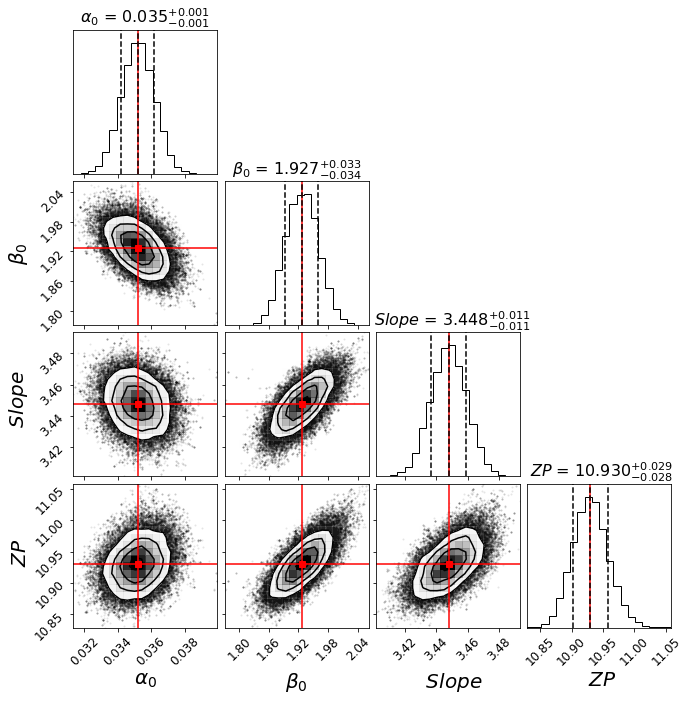

In [22]:
samples_ = samples_[np.where(samples_[:,0]<0.04)]
samples_ = samples_[np.where(samples_[:,1]>1.75)]
# samples_ = samples_[np.where(samples_[:,2]>4)]
samples_ = samples_[np.where(samples_[:,3]>10.8)]


# samples_[:,1] -= 0.4*4.58

theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples_, 
                            [16, 50, 84],
                            axis=0)))

labels = [r"$\alpha_0$", r"$\beta_0$", r"$\/\/\/\/Slope$", r"$\/\/ZP$"]
# labels = [r"$\alpha_0$", r"$\/\/\/\/Slope$", r"$\/\/ZP$"]

truths=[t[0] for t in theta]
fig = corner.corner(samples_, truth_color='r', labels=labels,
                    truths=truths, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_kwargs={"fontsize": 16}, 
                    title_fmt=".3f")


for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
    
    lbl = ax.xaxis.get_label()
    lbl.set_fontsize(20)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)
    lbl.set_linespacing(20)
    lbl = ax.yaxis.get_label()
    lbl.set_fontsize(20)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)

